In [1]:
import numpy as np
import pandas as pd
import tarfile
import skimage.exposure
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import itertools
import time
import io

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.exposure
from sklearn.cluster import KMeans
from PIL import Image
import pandas as pd
import io


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy, sparse_categorical_crossentropy, CategoricalCrossentropy, MeanSquaredError

c:\miniconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\miniconda\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\miniconda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
data = pd.read_parquet("New_data.parquet")

In [3]:
# Define the ranges of indexes
ranges = [(86000, 86999), (88000, 89499)]

# Slice the data for each range and store in a list
sliced_data = [data.loc[start:end] for start, end in ranges]

# Concatenate the sliced dataframes into a single dataframe
data = pd.concat(sliced_data)

In [21]:
data

,image,label
86000,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,172
86001,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,172
86002,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,172
86003,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,172
86004,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,172
...,...,...
89495,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,178
89496,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,178
89497,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,178
89498,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,178


In [37]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.exposure
from sklearn.cluster import KMeans
from PIL import Image
import pandas as pd
import io

color_hist_feature = []
sift_features = []

# Create a SIFT object
sift = cv2.SIFT_create()

# Lists to store features and corresponding labels
features = []
labels = []

l_descp = []
l_hist = []

max_descriptors = 0
max_hist = 0
max_bow = 0

num_clusters = 1

# Iterate over all files and subfolders in the folder
for index, row in data.iterrows():
    # Read the image bytes from the 'image' column
    image_bytes = row['image']['bytes']

    # Create a BytesIO object to load the image data
    image_stream = io.BytesIO(image_bytes)

    # Open the image using PIL
    image = Image.open(image_stream)

    image = np.array(image)

    # Reshape the image to a desired shape (e.g., 32x32)
    image = cv2.resize(image, (32, 32))

    # Create histograms
    hist_phase, bins_phase = skimage.exposure.histogram(image)
    # color_hist_feature.append(hist_phase)

    # Assign visual words to each image and construct the BoVW representation
    bovw_features = []

    # Create a SIFT feature extraction
    # Convert the image to grayscale

    # Convert the image to grayscale if it is not already in grayscale format
    if len(image.shape) > 2 and image.shape[2] > 1:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    keypoints, descriptors = sift.detectAndCompute(gray, None)

    # Check if descriptors are computed
    if descriptors is not None and descriptors.shape[0] != 0:

        # Extract the label from the folder name
        labels.append(row["label"])

        # Bag of words
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(descriptors)

        bow_vector = kmeans.predict(descriptors)

        # Determine the maximum sizes of descriptors and histograms
        max_descriptors = max(max_descriptors, descriptors.shape[0])
        max_hist = max(max_hist, len(hist_phase))
        max_bow = max(max_bow, bow_vector.shape[0])

        # Append the features
        features.append([descriptors, hist_phase, bow_vector])
        l_descp.append(len(descriptors))
        l_hist.append(len(hist_phase))

# Pad or truncate the features to a fixed size
for i in range(len(features)):
    descriptors = features[i][0]
    hist_phase = features[i][1]
    bow_vector = features[i][2]

    pad_descriptors = max_descriptors - descriptors.shape[0]
    pad_hist = max_hist - len(hist_phase)
    pad_bow = max_bow - bow_vector.shape[0]

    if pad_descriptors > 0:
        descriptors = np.pad(descriptors, ((0, pad_descriptors), (0, 0)), mode='constant')
    else:
        descriptors = descriptors[:max_descriptors]

    # Reshape hist_phase and bow_vector to 1D arrays
    hist_phase = hist_phase.flatten()
    bow_vector = bow_vector.flatten()

    if pad_hist > 0:
        hist_phase = np.pad(hist_phase, (0, pad_hist), mode='constant')
    else:
        hist_phase = hist_phase[:max_hist]

    if pad_bow > 0:
        bow_vector = np.pad(bow_vector, (0, pad_bow), mode='constant')
    else:
        bow_vector = bow_vector[:max_bow]

    features[i] = np.concatenate((descriptors.flatten(), hist_phase, bow_vector), axis=0)


c:\miniconda\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\miniconda\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads.

In [39]:
np.array(features).shape

(2487, 5932)

In [40]:
np.array(labels).shape

(2487,)

In [41]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [42]:
print(np.array(X_train).shape)
print(np.array(X_test).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)

(1989, 5932)
(498, 5932)
(1989,)
(498,)


c:\miniconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Opti

Best Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Best Score: 0.34971132670674365
Accuracy: 0.3501259445843829


c:\miniconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


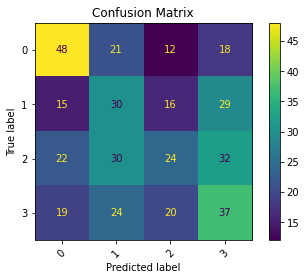

fit time 1341.6637625694275


In [ ]:
# Create an MLP classifier
mlp = MLPClassifier()

# Define the parameter grid for tuning
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'activation': ['tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(mlp, param_grid, cv=5)

start = time.time()

# Perform grid search to find the best parameters
grid_search.fit(X_train, y_train)

fit_time = time.time() - start

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the classifier with the best parameters
mlp_best = MLPClassifier(**best_params)
mlp_best.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp_best.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using plot_confusion_matrix
plot_confusion_matrix(mlp_best, X_test, y_test, display_labels=np.unique(np.array(labels)), xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

print("fit time", fit_time)

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Best Score: 0.3263972382596274
Accuracy: 0.31738035264483627


c:\miniconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


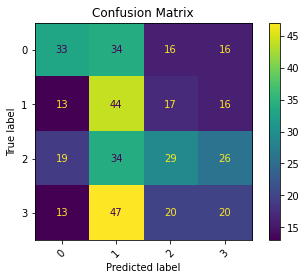

fit time 32.24065184593201


In [ ]:
knn = KNeighborsClassifier()

# Define the parameter grid for tuning
param_grid = {
    'n_neighbors': [4, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(knn, param_grid, cv=5)

start = time.time()

# Perform grid search to find the best parameters
grid_search.fit(X_train, y_train)

fit_time = time.time() - start

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the classifier with the best parameters
knn_best = KNeighborsClassifier(**best_params)
knn_best.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_best.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using plot_confusion_matrix
plot_confusion_matrix(knn_best, X_test, y_test, display_labels=np.unique(np.array(labels)), xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

print("fit time", fit_time)

Best Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Best Score: 0.30940023411304884
Accuracy: 0.35768261964735515


c:\miniconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


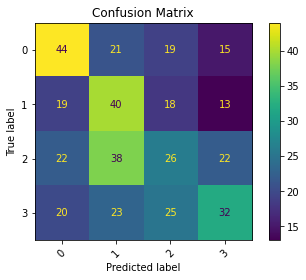

fit time 621.7309212684631


In [ ]:
# Create an SVM classifier
svm = SVC()

# Define the parameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(svm, param_grid, cv=5)

start = time.time()

# Perform grid search to find the best parameters
grid_search.fit(X_train, y_train)


fit_time = time.time() - start

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the classifier with the best parameters
svm_best = SVC(**best_params)
svm_best.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_best.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using plot_confusion_matrix
plot_confusion_matrix(svm_best, X_test, y_test, display_labels=np.unique(np.array(labels)), xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

print("fit time", fit_time)

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 300}
Best Score: 0.38563472273204813
Accuracy: 0.38353413654618473


c:\miniconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


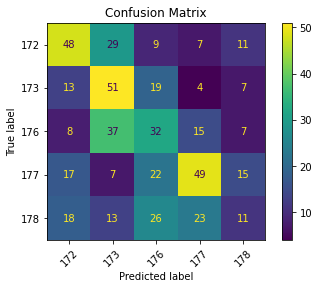

39.0230655670166


In [43]:
# Create a Random Forest classifier
rf = RandomForestClassifier()

# Define the parameter grid for tuning
param_grid = {'max_depth': [10], 'max_features': ['sqrt'], 'min_samples_split': [5], 'n_estimators': [300]}

#{
    #'n_estimators': [100, 200, 300],
    #'max_depth': [None, 5, 10],
    #'min_samples_split': [2, 5, 10],
    #'max_features': ['auto', 'sqrt', 'log2']
#}

# Create a GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5)

start = time.time()

# Perform grid search to find the best parameters
grid_search.fit(X_train, y_train)

fit_time = time.time() - start

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the classifier with the best parameters
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_best.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using plot_confusion_matrix
plot_confusion_matrix(rf_best, X_test, y_test, display_labels=np.unique(np.array(y_test)), xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

print(fit_time)

Sqeezenet

In [21]:
images = []
labels_deep = []

#data = pd.read_parquet("New_data.parquet")
#data = data[:3000]


# Iterate over all files and subfolders in the folder
for index, row in data.iterrows():
    # Read the image bytes from the 'image' column
    image_bytes = row['image']['bytes']

    # Create a BytesIO object to load the image data
    image_stream = io.BytesIO(image_bytes)

    # Open the image using PIL
    image = Image.open(image_stream)

    image = np.array(image)
    
    # Convert the image to grayscale if it is not already in grayscale format
    if len(image.shape) > 2 and image.shape[2] > 1:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Redimensionner l'image à la taille souhaitée (par exemple, 32x32)
    image = cv2.resize(image, (32, 32))

    # Convert the PIL image to a NumPy array
    image = np.array(gray) / 255

    images.append(gray)
    labels_deep.append(row["label"])

# Convert the lists to NumPy arrays
images = np.array(images)
labels_deep = np.array(labels_deep)

In [22]:
print(np.unique(labels_deep))
type(labels_deep)
new_labels = []
for x in labels_deep:
    if x == 172:
        new_labels.append(0)
    elif x == 173:
        new_labels.append(1)
    elif x == 176:
        new_labels.append(2)
    elif x == 177:
        new_labels.append(3)
    elif x == 178:
        new_labels.append(4)

labels_deep = np.array(new_labels)
print(labels_deep)


[172 173 176 177 178]
[0 0 0 ... 4 4 4]


In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_deep, test_size=0.2, random_state=42)

In [28]:
## Squeezenet structure

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, GlobalAveragePooling2D, Activation


#def fire_module(x, squeeze, expand):
    #squeezed = Conv2D(squeeze, (1, 1), activation='relu')(x)
    #expand1x1 = Conv2D(expand, (1, 1), activation='relu')(squeezed)
    #expand3x3 = Conv2D(expand, (3, 3), padding='same', activation='relu')(squeezed)
    #return concatenate([expand1x1, expand3x3])

def fire_module(x, squeeze, expand):
    squeezed = Conv2D(squeeze, (1, 1), activation='relu')(x)
    expand1x1 = Conv2D(expand, (1, 1), activation='relu')(squeezed)
    expand3x3 = Conv2D(expand, (3, 3), padding='same', activation='relu')(squeezed)
    return concatenate([expand1x1, expand3x3])


def SqueezeNet(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    x = Conv2D(96, (7, 7), strides=(2, 2), activation='relu', padding='same')(input_tensor)
    #x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 32, 128)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)

    x = Conv2D(num_classes, (1, 1), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)
    return model

In [34]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Recall, Precision
from sklearn.preprocessing import MinMaxScaler

# Define the number of folds for cross-validation and other hyperparameters
n_folds = 5  # Number of folds for cross-validation
learning_rate = 0.001
batch_size = 32
epochs = 100

# Encode the labels
#label_encoder = LabelEncoder()
#labels_deep = label_encoder.fit_transform(labels)

# Initialize lists to store the evaluation metrics for each fold
val_accuracy_per_fold = []
val_precision_per_fold = []
val_recall_per_fold = []
val_f1_score_per_fold = []

# Perform cross-validation using StratifiedKFold
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

for fold, (train_index, val_index) in enumerate(skf.split(images, labels_deep)):
    print(f"Fold {fold + 1}")
    print(images.shape)
    height = images.shape[1]
    width = images.shape[2]
    channels = None
    #X_train_fold = images[train_index]
    #print(train_index)
    #print(type(train_index))
    y_train_fold = labels_deep[train_index]
    #print(y_train_fold)
    #X_train_fold = images[train_index].reshape(-1, height, width)
    #X_val_fold = images[val_index].reshape(-1, height, width)
    #X_train_fold = np.expand_dims(images[train_index], axis=3)
    #X_val_fold = np.expand_dims(images[val_index], axis=3)
    
    #X_val_fold = images[val_index]
    y_val_fold = labels_deep[val_index]


    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_fold = label_encoder.fit_transform(y_train_fold)
    y_val_fold = label_encoder.fit_transform(y_val_fold)

    scaler = MinMaxScaler()

    X_train_fold_normalized = scaler.fit_transform(X_train_fold.reshape(-1, height * width))
    X_val_fold_normalized = scaler.transform(X_val_fold.reshape(-1, height * width))

    # Reshape the normalized data back to the original shape
    X_train_fold = X_train_fold_normalized.reshape(X_train_fold.shape)
    X_val_fold = X_val_fold_normalized.reshape(X_val_fold.shape)

    #print(np.array(X_train))
    #print(np.array(X_test))
    #print(np.array(y_train))
    #print(np.array(y_test))
    
    
    # Define the input shape and number of classes
    input_shape = X_train_fold.shape[1:]  # Input image shape
    num_classes = len(np.unique(labels_deep))

    # Create the LeNet model
    model = SqueezeNet(input_shape, num_classes)

    optimizer = RMSprop(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

    start = time.time()

    history = model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=epochs, validation_data=(X_val_fold, y_val_fold))

    fit_time = time.time() - start

    # Evaluate the model on validation data
    y_val_pred = model.predict(X_val_fold)
    y_val_pred_labels = np.argmax(y_val_pred, axis=1)
    y_val_true_labels = y_val_fold
    y_val_pred_labels = np.round(y_val_pred_labels).astype(int)
    y_val_true_labels = np.round(y_val_true_labels).astype(int)
    #np.argmax(np.reshape(y_val_fold, (-1, 1)), axis=1)
    val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
    #precision = precision_score(y_val_true_labels, y_val_pred_labels, average='macro')
    #recall = recall_score(y_val_true_labels, y_val_pred_labels, average='macro')
    #f1 = f1_score(y_val_true_labels, y_val_pred_labels, average='macro')

    val_accuracy_per_fold.append(val_accuracy)
    #val_precision_per_fold.append(precision)
    #val_recall_per_fold.append(recall)
    #val_f1_score_per_fold.append(f1)

# Calculate and display the mean and standard deviation of the evaluation metrics across folds
print("Cross-validation results:")
print(f"Mean validation accuracy: {np.mean(val_accuracy_per_fold):.4f} (+/- {np.std(val_accuracy_per_fold):.4f})")
print("fit time", fit_time)

Fold 1
(2500, 64, 64)
Epoch 1/3
40/40 [==============================] - 9s 166ms/step - loss: 1.6098 - accuracy: 0.1984 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 2/3
40/40 [==============================] - 6s 163ms/step - loss: 1.6094 - accuracy: 0.2000 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 3/3
40/40 [==============================] - 2s 39ms/step
Fold 2
(2500, 64, 64)
Epoch 1/3
40/40 [==============================] - 10s 184ms/step - loss: 1.6097 - accuracy: 0.1944 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 2/3
40/40 [==============================] - 7s 179ms/step - loss: 1.6094 - accuracy: 0.2000 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 3/3
40/40 [==============================] - 2s 39ms/step
Cross-validation results:
Mean validation accuracy: 0.2000 (+/- 0.0000)
fit time 24.131065130233765


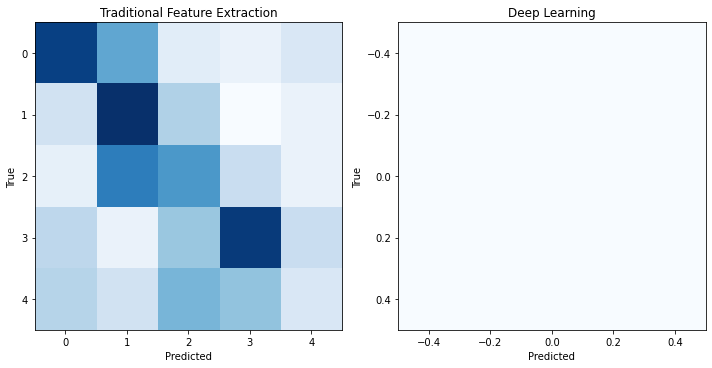

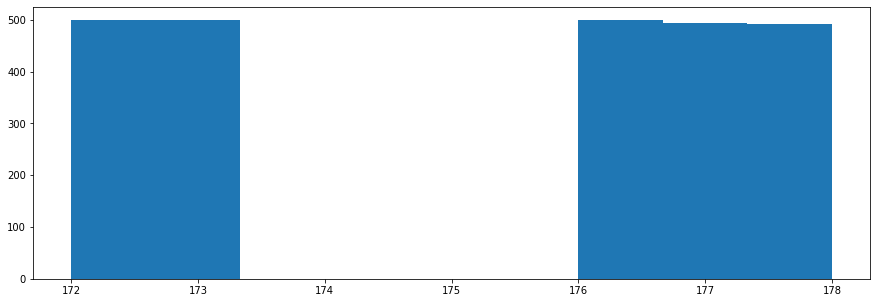

dict_keys([172, 173, 176, 177, 178])


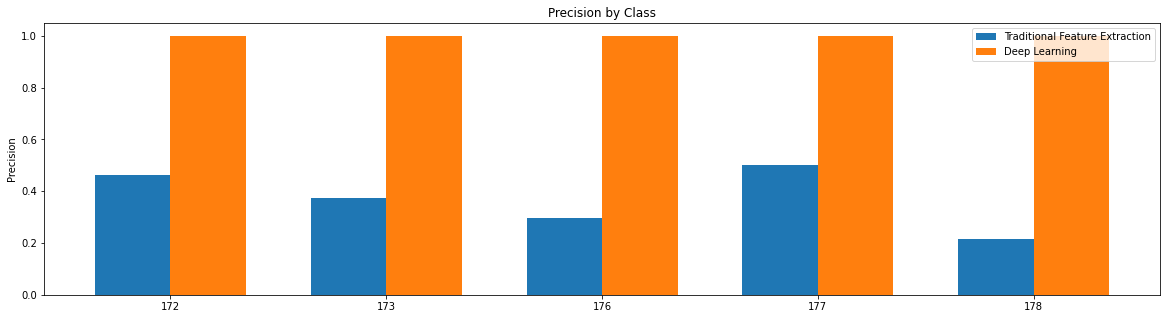

There is no significant difference between the two approaches.


c:\miniconda\lib\site-packages\numpy\core\fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\miniconda\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [47]:
## Detailed comparison : Squeezenet and RF

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from scipy.stats import ttest_rel
from collections import Counter

y_test = y_test[:498]

# Assume you have obtained the predictions and true labels for each approach
traditional_predictions = y_pred
deep_learning_predictions = y_val_pred_labels
true_labels_deep_learning = y_val_true_labels
true_labels_traditional = y_test

# Compute the confusion matrices
traditional_cm = confusion_matrix(y_test, y_pred)
deep_learning_cm = confusion_matrix(y_val_true_labels, y_val_pred_labels)

# Plot the confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(traditional_cm, cmap='Blues')
axes[0].set_title('Traditional Feature Extraction')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[1].imshow(deep_learning_cm, cmap='Blues')
axes[1].set_title('Deep Learning')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
plt.tight_layout()
plt.show()

#Plot Class
plt.figure(figsize=(15,5))
plt.hist(labels, bins = 9)
plt.show()

# Calculate precision, recall, and F1-score for each class
traditional_metrics = precision_recall_fscore_support(true_labels_traditional, traditional_predictions, average=None)
deep_learning_metrics = precision_recall_fscore_support(true_labels_deep_learning, deep_learning_predictions, average=None)

# Plot class-specific metrics
classes = Counter(labels)
print(classes.keys())
x = np.arange(len(classes.keys()))
width = 0.35
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(x - width/2, traditional_metrics[0], width, label='Traditional Feature Extraction')
ax.bar(x + width/2, deep_learning_metrics[0], width, label='Deep Learning')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Precision')
ax.set_title('Precision by Class')
ax.legend()
plt.show()

# Perform statistical test
_, p_value = ttest_rel(traditional_metrics[0][1], deep_learning_metrics[0])
if p_value < 0.05:
    print("There is a significant difference between the two approaches.")
else:
    print("There is no significant difference between the two approaches.")
